# Transfer Learning

Welcome to this assignment! You are going to use a technique called `Transfer Learning` in which you utilize an already trained network to help you solve a similar problem to the one it was originally trained to solve.

Let's get started!

_**NOTE:** Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

In [89]:
# grader-required-cell

import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Dataset

For this assignment, you will use the `Horse or Human dataset`, which contains images of horses and humans.

Download the `training` and `validation` sets by running the cell below:

In [2]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/learning-datasets/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

This dataset already has an structure that is compatible with Keras' `flow_from_directory` so you don't need to move the images into subdirectories as you did in the previous assignments. However, it is still a good idea to save the paths of the images so you can use them later on:

In [91]:
# grader-required-cell

# Define the training and validation base directories
train_dir = 'horse-or-human'
validation_dir = 'validation-horse-or-human'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Now take a look at a sample image of each one of the classes:

Sample horse image:


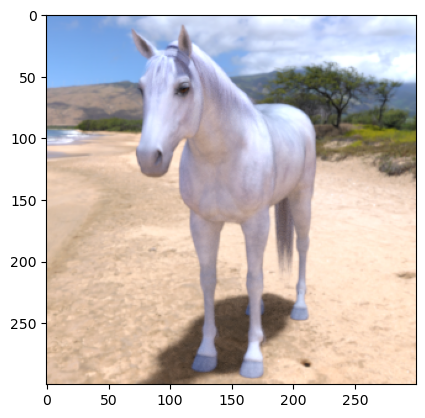


Sample human image:


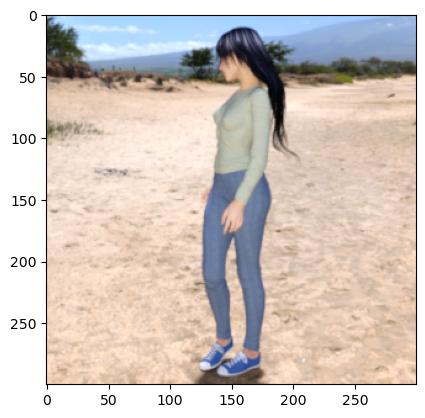

In [93]:
# grader-required-cell

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

`matplotlib` makes it easy to see that these images have a resolution of 300x300 and are colored, but you can double check this by using the code below:

In [95]:
# grader-required-cell

# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


As expected, the sample image has a resolution of 300x300 and the last dimension is used for each one of the RGB channels to represent color.

## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [97]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Creates the training and validation data generators

    Args:
      TRAINING_DIR (string): directory path containing the training images
      VALIDATION_DIR (string): directory path containing the testing/validation images

    Returns:
      train_generator, validation_generator: tuple containing the generators
    """
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class with data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.,  # Normalizing pixel values
        rotation_range=40,  # Random rotation between 0 and 40 degrees
        width_shift_range=0.2,  # Horizontal shift
        height_shift_range=0.2,  # Vertical shift
        shear_range=0.2,  # Shearing transformations
        zoom_range=0.2,  # Random zoom
        horizontal_flip=True,  # Flip horizontally
        fill_mode='nearest'  # Filling empty pixels after transformations
    )

    # Pass in the appropriate arguments to the flow_from_directory method for training
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        target_size=(300, 300),  # Resize images to 300x300 pixels
        batch_size=32,
        class_mode='binary'  # Binary classification (horse or human)
    )

    # Instantiate the ImageDataGenerator class for validation data (without augmentation)
    validation_datagen = ImageDataGenerator(rescale=1.0/255.)  # Only normalize validation data

    # Pass in the appropriate arguments to the flow_from_directory method for validation
    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        target_size=(300, 300),  # Resize validation images to 300x300 pixels
        batch_size=32,
        class_mode='binary'  # Binary classification
    )

    ### END CODE HERE
    return train_generator, validation_generator

In [99]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


**Expected Output:**
```
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
```

## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [8]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-10-26 14:39:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.6MB/s    in 4.7s    

2024-10-26 14:39:54 (17.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Now load the `InceptionV3` model and save the path to the weights you just downloaded:

In [101]:
# grader-required-cell

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Complete the `create_pre_trained_model` function below. You should specify the correct `input_shape` for the model (remember that you set a new resolution for the images instead of the native 300x300) and make all of the layers non-trainable:

In [103]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):
    """
    Initializes an InceptionV3 model.

    Args:
      local_weights_file (string): path pointing to a pretrained weights H5 file

    Returns:
      pre_trained_model: the initialized InceptionV3 model
    """
    ### START CODE HERE
    # Initialize the InceptionV3 model without the top layer and with the input shape (150, 150, 3)
    pre_trained_model = InceptionV3(input_shape=(300, 300, 3),
                                    include_top=False,
                                    weights=None)

    # Load the pre-trained weights into the model
    pre_trained_model.load_weights(local_weights_file)

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

    ### END CODE HERE

    return pre_trained_model

Check that everything went well by comparing the last few rows of the model summary to the expected output:

In [105]:
# grader-required-cell

pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

**Expected Output:**
```
batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0]
__________________________________________________________________________________________________
mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
                                                                activation_276[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
                                                                activation_280[0][0]             
__________________________________________________________________________________________________
activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0]
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
                                                                mixed9_1[0][0]                   
                                                                concatenate_5[0][0]              
                                                                activation_281[0][0]             
==================================================================================================
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784


```

To check that all the layers in the model were set to be non-trainable, you can also run the cell below:

In [107]:
# grader-required-cell

total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

## Creating callbacks for later

You have already worked with callbacks before so the callback to stop training once an accuracy of 99.9% is reached, is provided for you:

In [109]:
# grader-required-cell

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## Pipelining the pre-trained model with your own

Now that the pre-trained model is ready, you need to "glue" it to your own model to solve the task at hand.

For this you will need the last output of the pre-trained model, since this will be the input for your own. Complete the `output_of_last_layer` function below.

**Note:** For grading purposes of the first assingment use the `mixed7` layer as the last layer of the pre-trained model. However, you can come back here and play around with this.

In [111]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
    """
    Gets the last layer output of a model

    Args:
      pre_trained_model (tf.keras Model): model to get the last layer output from

    Returns:
      last_output: output of the model's last layer
    """
    ### START CODE HERE
    # Get the desired layer (we assume 'mixed7' is the last layer we want)
    last_desired_layer = pre_trained_model.get_layer('mixed7')

    # Get the output of that layer
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    ### END CODE HERE

    return last_output

Check that everything works as expected:

In [113]:
# grader-required-cell

last_output = output_of_last_layer(pre_trained_model)

last layer output:  <KerasTensor shape=(None, 17, 17, 768), dtype=float32, sparse=False, name=keras_tensor_858>


**Expected Output (if `mixed7` layer was used):**
```
last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
```

Now you will create the final model by adding some additional layers on top of the pre-trained model.

Complete the `create_final_model` function below. You will need to use Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional) for this since the pretrained model has been created using it.

Let's double check this first:

In [115]:
# grader-required-cell

# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.models.functional.Functional'>


To create the final model, you will use Keras' Model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

Note that you can get the input from any existing model by using its `input` attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [117]:
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
    """
    Appends a custom model to a pre-trained model

    Args:
      pre_trained_model (tf.keras Model): model that will accept the train/test inputs
      last_output (tensor): last layer output of the pre-trained model

    Returns:
      model: the combined model
    """
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)

    ### START CODE HERE

    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)

    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)

    # Add a final sigmoid layer for binary classification (since it's a two-class problem)
    x = layers.Dense(1, activation='sigmoid')(x)

    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [119]:
# grader-required-cell

# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 236,256,161 total parameters in this model.
There are 227,280,897 trainable parameters in this model.


**Expected Output:**
```
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.
```

Wow, that is a lot of parameters!

After submitting your assignment_1 later, try re-running this notebook but use the original resolution of 300x300, you will be surprised to see how many more parameters are for that case.

Now train the model:

In [121]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 89s - 3s/step - accuracy: 0.8890 - loss: 0.7652 - val_accuracy: 0.7852 - val_loss: 0.7228
Epoch 2/100
33/33 - 80s - 2s/step - accuracy: 0.9932 - loss: 0.0299 - val_accuracy: 0.9492 - val_loss: 0.1804
Epoch 3/100
33/33 - 80s - 2s/step - accuracy: 0.9932 - loss: 0.0269 - val_accuracy: 0.9727 - val_loss: 0.1003
Epoch 4/100
33/33 - 80s - 2s/step - accuracy: 0.9971 - loss: 0.0099 - val_accuracy: 0.9023 - val_loss: 0.3442
Epoch 5/100

Reached 99.9% accuracy so cancelling training!
33/33 - 80s - 2s/step - accuracy: 0.9990 - loss: 0.0055 - val_accuracy: 0.9141 - val_loss: 0.2644


The training should have stopped after less than 10 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!

Now take a quick look at the training and validation accuracies for each epoch of training:

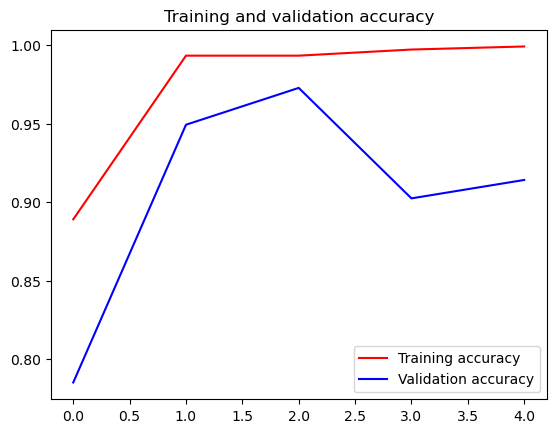

<Figure size 640x480 with 0 Axes>

In [123]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

**Congratulations on finishing this assignment!**

You have successfully implemented a convolutional neural network that leverages a pre-trained network to help you solve the problem of classifying humans from horses.

**Keep it up!**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


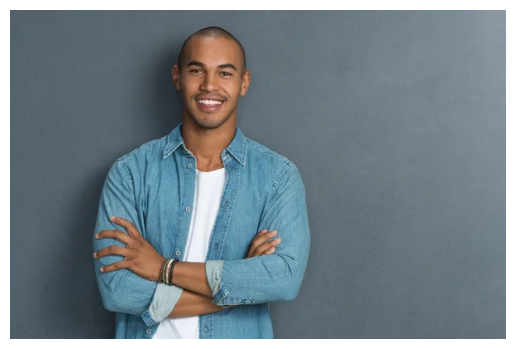

h1.jpg is a Human with 100.00% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


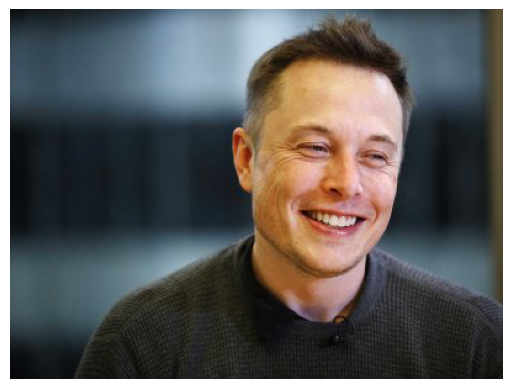

h2.jpg is a Human with 99.64% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


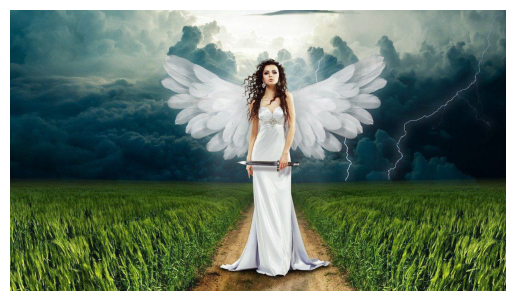

h3.jpg is a Human with 99.38% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


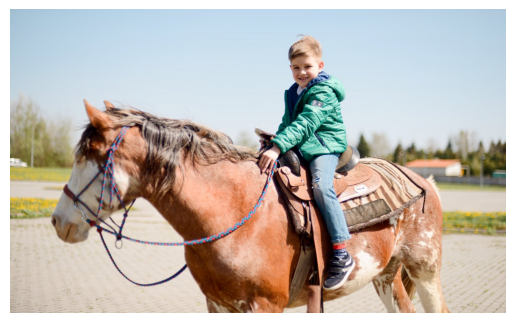

h4.jpg is a Horse with 63.58% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


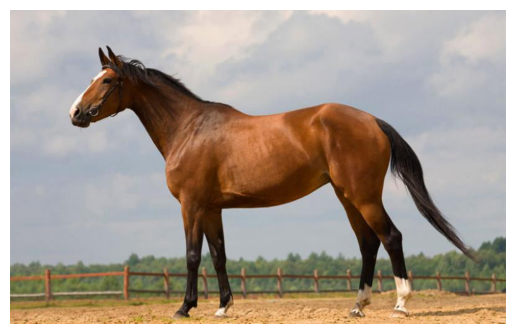

ho1.jpg is a Horse with 100.00% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


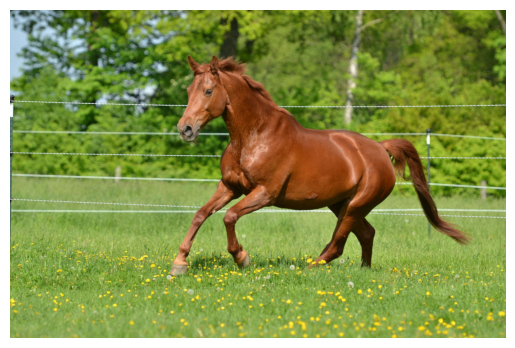

ho2.jpg is a Horse with 99.96% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


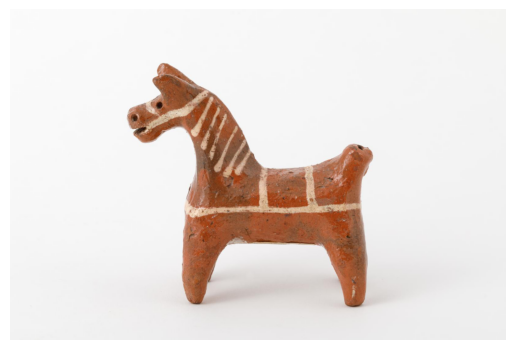

ho3.jpg is a Human with 97.49% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


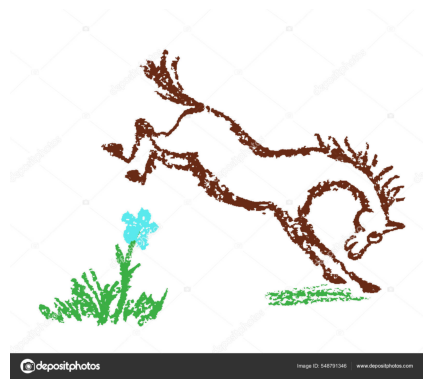

ho4.jpg is a Human with 99.92% confidence.


In [125]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Directory where your test images are stored
test_images_dir = 'lab7_1_imgs'  # Заміни цей шлях на свій шлях до папки з тестовими зображеннями

# Get all .jpg images from the directory
test_image_paths = [os.path.join(test_images_dir, fname) for fname in os.listdir(test_images_dir) if fname.endswith('.jpg')]

# Function to preprocess and display the test images
def predict_and_display_images(image_paths, model):
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(300, 300))  # Resize to 300x300
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize image
        
        # Predict the class
        prediction = model.predict(img_array)
        
        # Display the image and prediction
        plt.imshow(image.load_img(img_path))
        plt.axis('off')
        plt.show()
        
        if prediction < 0.5:
            print(f'{os.path.basename(img_path)} is a Horse with {100 - prediction[0][0] * 100:.2f}% confidence.')
        else:
            print(f'{os.path.basename(img_path)} is a Human with {prediction[0][0] * 100:.2f}% confidence.')

# Call the function with your model and test images
predict_and_display_images(test_image_paths, model)